In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels


import matplotlib.pyplot as plt

from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


__Types of Recommender System__
1. Simple recommender systems: is based on movie popularity independent of the user preferences. Too simple! But the basic idea of using movie prior popularity is a component in the system that we will develop as we will see.
2. Meta data/ Content based: this is based on history of the user preferences. Not taking advantage of other users similarity.
3. Collaborative filtering: takes advantages of similar users history, in addition to the same user past preferences, to recommend new items.

## Simple Recommender System
Build Simple Recommender System based on the metric below:
- weightedRating(WR) = ((v/v+m).R) + ((m/v+m).C)
 * v >> is the number of votes for the movie. (vote_count)
 * m >> is the min votes required to be listed in chart. (based on negative vote)
 * R >> is the average rating of the movie. (vote_average)
 * C >> is the mean vote across the the whole report. (calculate from data)

Note:
- The parameter m represents the minimum number of votes required for a movie to be considered in the ranking. It acts as a threshold to ensure that only movies with enough votes (representing a significant audience) are included in the calculation.


# Load Dataset

In [ ]:
metadata = pd.read_csv('dataset/movies_metadata.csv', low_memory=False)
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [ ]:
print(metadata.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [ ]:
metadata.shape

(45466, 24)

In [ ]:
# calcuate c
C= metadata['vote_average'].mean()
# calculate M
M = metadata['vote_count'].quantile(0.90) # means that 90% of the movies have fewer votes, and only 10% have more votes

# filter out all qualified movies into a new DataFrame
Q_movies = metadata.copy().loc[metadata['vote_count'] >= M]

print(C)
print(M)

5.618207215134185
160.0


In [ ]:
print(Q_movies.shape)
print(Q_movies.columns)

(4555, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [ ]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, M=M, C=C):
    v = x['vote_count']
    R = x['vote_average']

    return (v/(v+M) * R) + (M/(M+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
Q_movies['score'] = Q_movies.apply(weighted_rating, axis=1)

#Sort movies based on score calculated above
Q_movies = Q_movies.sort_values('score', ascending=False)
#Print the top 15 movies
Q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


# Content based recommender systems

In [ ]:
# Print overviews of the first 5 movies.
print(metadata['overview'].head())

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object


In [ ]:
metadata.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

* we have 954 null values in overview texts we should fill it and then
* Calculate the TF-IDF transform for the movies overview texts

In [ ]:
# fill null valuse
metadata['overview'] = metadata['overview'].fillna('')

# remove stop words ,build vocab and then bulid tfidf matrix using Tfidfvectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata['overview'])
tfidf_matrix.shape

(45466, 75827)

Compute the pair-wise cosine similarity between all overviews of movies.


Remember: since that:

$$x.y = ||x||.||y||.cos(\theta)$$

So
$$cos(\theta) = \frac{x.y}{||x||||y||}$$

So we can use the `linear_kernel` from sklearn, which is faster than `cosine_similarity`

In [ ]:
cos_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

Implement the function `get_recommendations` that produces 10 most similar movies, based on cosine_similarity between the TF-IDF scores of descriptions

In [ ]:
#Construct a reverse map of indices and movie titles , key is title and value is index
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()
indices

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Subdue                         45461
Century of Birthing            45462
Betrayal                       45463
Satan Triumphant               45464
Queerama                       45465
Length: 45466, dtype: int64

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendation(title,cos_sim=cos_sim):
     # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cos_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

     # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

     # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

print(get_recommendation('The Dark Knight Rises'))



12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object


we want to recommend movies based on some extra metadata _features_, like `'cast', 'crew', 'keywords', 'genres'`. One important difference is that you use the `CountVectorizer()` instead of TF-IDF. This is because you do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

Unlike TF-IDF (Term Frequency-Inverse Document Frequency), which down-weights terms that appear frequently across documents, CountVectorizer simply counts occurrences.
In this context, frequent appearances of an actor, director, or genre are not less important. For example, a famous actor appearing in many movies should still be highly relevant for recommendations.

In [ ]:
# Load credit ,keywords
credits= pd.read_csv('dataset/credits.csv')
keywords = pd.read_csv('dataset/keywords.csv')

In [ ]:
# Remove rows with bad IDs.
metadata = metadata.drop([19730, 29503, 35587])

In [ ]:
# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

In [ ]:
# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [ ]:
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [ ]:
metadata.shape

(46628, 27)

In [ ]:
# Limit the data for memory size
metadata = metadata[:10000]

In [ ]:
metadata.shape

(10000, 27)

In [ ]:
# converting raw data into a usable format for feature engineering and analysis.
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:

# Define new director, cast, genres and keywords features that are in a suitable form.
metadata['director'] = metadata['crew'].apply(get_director)


In [ ]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [ ]:
# Print the new features of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(10)


,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,"[baby, midlife crisis, confidence]",[Comedy]
5,Heat,"[Al Pacino, Robert De Niro, Val Kilmer]",Michael Mann,"[robbery, detective, bank]","[Action, Crime, Drama]"
6,Sabrina,"[Harrison Ford, Julia Ormond, Greg Kinnear]",Sydney Pollack,"[paris, brother brother relationship, chauffeur]","[Comedy, Romance]"
7,Tom and Huck,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",Peter Hewitt,[],"[Action, Adventure, Drama]"
8,Sudden Death,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,"[terrorist, hostage, explosive]","[Action, Adventure, Thriller]"
9,GoldenEye,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]",Martin Campbell,"[cuba, falsely accused, secret identity]","[Adventure, Action, Thriller]"


In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:

# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])


In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather', cosine_sim2)

1926           The Godfather: Part III
1187            The Godfather: Part II
7961    The Night of the Following Day
7732                          Mitchell
1174                    Apocalypse Now
1640                  Ill Gotten Gains
3475        Jails, Hospitals & Hip-Hop
4000                  Gardens of Stone
5285                       The Gambler
5                                 Heat
Name: title, dtype: object

### Collaborative filtering
- Dataset : MovieLens

In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
ratings = pd.read_csv('/content/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


`'pd.crosstab(ratings.userId, ratings.movieId)'` creates a cross-tabulation table where the rows represent unique values from ratings.userId, and the columns represent unique values from ratings.movieId.
The values in the table represent the frequency of how often each user has rated a specific movie

In [ ]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Extract the user/movie rating matrix from MovieLens dataset using pandas, for the top 15 movies and users.

In [ ]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]


top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

In [ ]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

C:\Users\elkhwaga\AppData\Local\Temp\ipykernel_23860\366748944.py:1: FutureWarning: The provided callable <function sum at 0x00000196A8F75BC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


- Encode the user id, and movie id categorical variables, using sklean LabelEncoder to be used with the Embedding layer.

In [3]:
# userId
le = LabelEncoder()
ratings['user']=le.fit_transform(ratings.userId.values)

# # movie id
le_m = LabelEncoder()
ratings['movie']=le.fit_transform(ratings.movieId.values)


# # get num_users , num_moveis, min_rating ,max_rating
num_users =ratings['user'].nunique()
num_movies =ratings['movie'].nunique()

# # rating
ratings['rating']=ratings['rating'].values.astype('float32')
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])


num_users, num_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

__ Build the collaborative filtering model, using keras Embedding and Dot layers__

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding_LUT        │ (None, 1, 50)          │         30,500 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding_LUT       │ (None, 1, 50)          │        486,200 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 50)             │              0 │ user_embedding_LUT[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 50)             │              0 │ movie_embedding_LUT[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_measure (Dot)  │ (None, 1)              │              0 │ reshape_4[0][0],       │
│                           │                        │                │ reshape_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

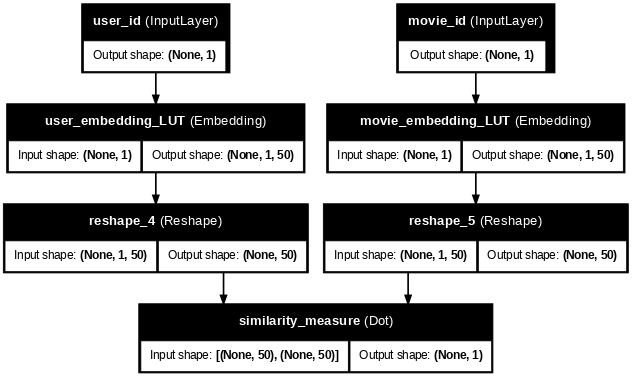

In [6]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(num_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,), name='movie_id')
movie_emb = layers.Embedding(num_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1, name='similarity_measure')([user_emb, movie_emb])

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=[metrics.RootMeanSquaredError()],
              optimizer=optimizers.Adam(learning_rate=0.001))

# Show model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True,dpi=60)



In [7]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90752, 2) (90752,)
(10084, 2) (10084,)


In [10]:
# Compile the model
model.compile(loss='mse',  metrics=[metrics.RootMeanSquaredError()],
              optimizer=optimizers.Adam(learning_rate=0.001))
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 12.2287 - root_mean_squared_error: 3.4915 - val_loss: 3.1978 - val_root_mean_squared_error: 1.7867
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.3607 - root_mean_squared_error: 1.5318 - val_loss: 1.6329 - val_root_mean_squared_error: 1.2740
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1902 - root_mean_squared_error: 1.0860 - val_loss: 1.3606 - val_root_mean_squared_error: 1.1611
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8786 - root_mean_squared_error: 0.9305 - val_loss: 1.2748 - val_root_mean_squared_error: 1.1228
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7460 - root_mean_squared_error: 0.8553 - val_loss: 1.2414 - val_root_mean_squared_error: 1.1073


Lambda Layer: Customizes the output by rescaling the normalized value back to the original rating range

Sigmoid Activation: Maps the dot product output (a scalar) to a value between 0 and 1.

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 50)          │         30,500 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 50)          │        486,200 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_26 (Reshape)      │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape)      │ (None, 50)             │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_bias (Embedding)     │ (None, 1, 1)           │            610 │ user_id[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_bias (Embedding)    │ (None, 1, 1)           │          9,724 │ movie_id[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_measure (Dot)  │ (None, 1)              │              0 │ reshape_26[0][0],      │
│                           │                        │                │ reshape_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_27 (Reshape)      │ (None, 1)              │              0 │ user_bias[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_29 (Reshape)      │ (None, 1)              │              0 │ movie_bias[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 1)              │              0 │ similarity_measure[0]… │
│                           │                        │                │ reshape_27[0][0],      │
│                           │                        │                │ reshape_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_scaling            │ (None, 1)              │              0 │ add_5[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ rating_scaling[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 527,034 (2.01 MB)

 Trainable params: 527,034 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


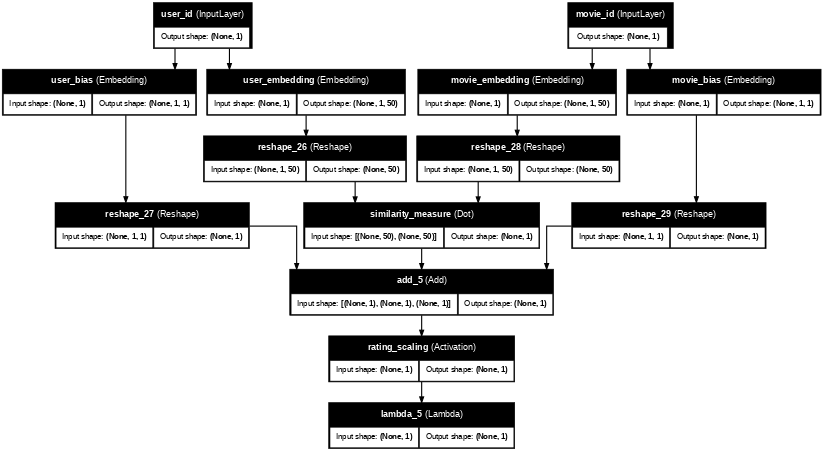

In [17]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,),name='user_id')
user_emb = layers.Embedding(num_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='user_embedding')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(num_users, 1, embeddings_regularizer=regularizers.l2(1e-6),name='user_bias')(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,),name='movie_id')
movie_emb = layers.Embedding(num_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='movie_embedding')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(num_movies, 1, embeddings_regularizer=regularizers.l2(1e-6),name='movie_bias')(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Dot(axes=1,name='similarity_measure')([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Activation('sigmoid',name='rating_scaling')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()],
              optimizer=optimizers.Adam(learning_rate=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True,dpi=40)

In [18]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.4249 - root_mean_squared_error: 1.1923 - val_loss: 0.8570 - val_root_mean_squared_error: 0.9251
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7292 - root_mean_squared_error: 0.8529 - val_loss: 0.7479 - val_root_mean_squared_error: 0.8632
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5468 - root_mean_squared_error: 0.7372 - val_loss: 0.7278 - val_root_mean_squared_error: 0.8505
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4221 - root_mean_squared_error: 0.6460 - val_loss: 0.7298 - val_root_mean_squared_error: 0.8509
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3204 - root_mean_squared_error: 0.5606 - val_loss: 0.7426 - val_root_mean_squared_error: 0.8576


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 1, 50)          │         30,500 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 1, 50)          │        486,200 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_42 (Reshape)      │ (None, 50)             │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_44 (Reshape)      │ (None, 50)             │              0 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 1)           │            610 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 1, 1)           │          9,724 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 100)            │              0 │ reshape_42[0][0],      │
│ (Concatenate)             │                        │                │ reshape_44[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_43 (Reshape)      │ (None, 1)              │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_45 (Reshape)      │ (None, 1)              │              0 │ embedding_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 100)            │              0 │ concatenate_3[0][0],   │
│                           │                        │                │ reshape_43[0][0],      │
│                           │                        │                │ reshape_45[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 10)             │          1,010 │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 10)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             11 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_9 (Lambda)         │ (None, 1)              │              0 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 528,055 (2.01 MB)

 Trainable params: 528,055 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


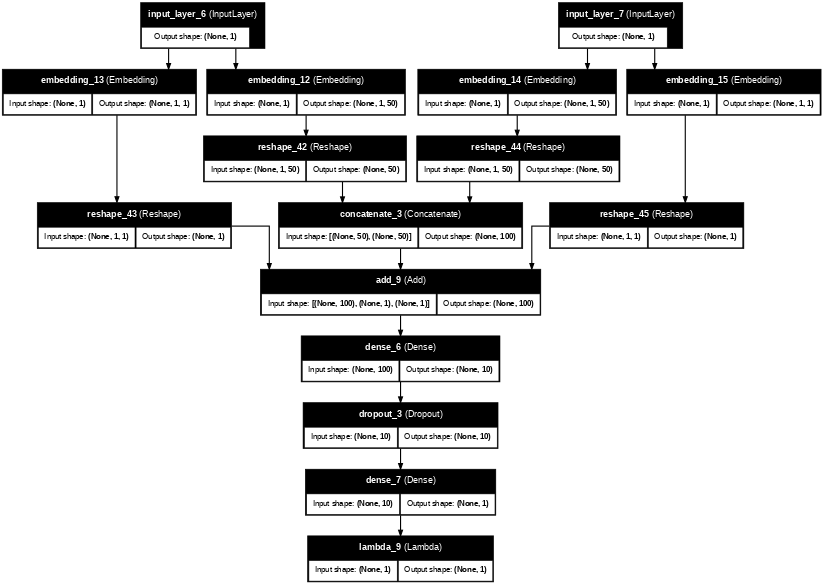

In [22]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(num_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(num_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(num_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(num_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=[metrics.RootMeanSquaredError()],
              optimizer=optimizers.Adam(learning_rate=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True,dpi=40)

In [23]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0820 - root_mean_squared_error: 1.0379 - val_loss: 0.8018 - val_root_mean_squared_error: 0.8952
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7603 - root_mean_squared_error: 0.8716 - val_loss: 0.7733 - val_root_mean_squared_error: 0.8788
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7168 - root_mean_squared_error: 0.8460 - val_loss: 0.7746 - val_root_mean_squared_error: 0.8794
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6987 - root_mean_squared_error: 0.8350 - val_loss: 0.7829 - val_root_mean_squared_error: 0.8839
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6935 - root_mean_squared_error: 0.8317 - val_loss: 0.7891 - val_root_mean_squared_error: 0.8871


In [28]:
# function to make recommendation based on my collaborative filtering model
def predict_ratings(model, user_id,movie_id, num_recommendations=10):
  user_array = np.array([user_id] * len(movie_id))  # Repeat user ID for all movies
  movie_array = np.array(movie_id)
  predictions = model.predict([user_array, movie_array])

  # make recommedation
  recommendations = np.argsort(-predictions.flatten())[:num_recommendations]
  return recommendations


In [27]:
def get_unrated_movies(ratings, user_id, all_movie_ids):
    """
    Get the list of movies the user has not rated yet.

    Args:
        ratings: DataFrame containing user-movie ratings.
        user_id: The ID of the user.
        all_movie_ids: List of all movie IDs in the dataset.

    Returns:
        A list of movie IDs the user has not rated.
    """
    rated_movies = ratings[ratings['user'] == user_id]['movie'].tolist()
    unrated_movies = list(set(all_movie_ids) - set(rated_movies))
    return unrated_movies

In [30]:
# Get all unique movie IDs
all_movie_ids = ratings['movie'].unique()

# Specify the user ID for whom to recommend movies
user_id = 1

# Get unrated movies for the user
unrated_movies = get_unrated_movies(ratings, user_id, all_movie_ids)

# Predict ratings for unrated movies
predicted_ratings = model.predict([np.array([user_id] * len(unrated_movies)), np.array(unrated_movies)])

# Get movie indices sorted by predicted rating
recommendations = np.argsort(predicted_ratings.flatten())[::-1]  # Sort in descending order

# Get the top 10 recommended movie IDs
top_recommendations = [unrated_movies[i] for i in recommendations[:10]]

# Display top 10 recommendations
print("Top 10 Recommendations for User", user_id)
for movie_id in top_recommendations:
    print(f"Movie ID: {movie_id}")

303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Top 10 Recommendations for User 1
Movie ID: 9600
Movie ID: 882
Movie ID: 4390
Movie ID: 796
Movie ID: 7584
Movie ID: 1761
Movie ID: 731
Movie ID: 6427
Movie ID: 2422
Movie ID: 917
